# Municipalities geo-data collector
The following scripts can be used to get geo-data about municipalities in Lombardy. 

In [30]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

# import Overpass API from OpenStreetMap
from OSMPythonTools.overpass import Overpass as ovp
from shapely.geometry import Point
from datetime import datetime

## Load map data
Must have the folder containing the shapefile for the municipalities in the same directory of the script. 
The shape file containing all municipalities can be found at the following link: [Geoportale Lombardia](https://www.geoportale.regione.lombardia.it/metadati?p_p_id=detailSheetMetadata_WAR_gptmetadataportlet&p_p_lifecycle=0&p_p_state=normal&p_p_mode=view&_detailSheetMetadata_WAR_gptmetadataportlet_identifier=r_lombar%3A0e3f85ec-6494-407b-a6d4-66ff9ea74bd4&_jsfBridgeRedirect=true).

/home/paolo/.local/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


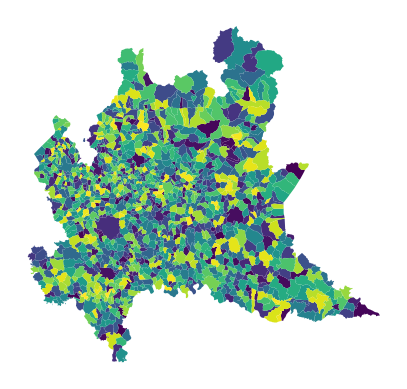

In [31]:
map = gpd.read_file('./REGIONE_LOMBARDIA/Comuni_correnti_poligonali.shp')
map = map.to_crs({'init': 'epsg:4326'}) # set a Coordinate Reference System
map['NOME_COM'] = map['NOME_COM'].str.replace('`', "'")

# Plot choropleth map
ax = map.plot(column="OBJECTID")
ax.set_axis_off()

## Collecting data about the Municipalities
In order to collect data (the center of the municipalities in this particular instance), we make a call to the Overpass API (from OpenStreetMap) for each of the areas of interest.

In [32]:
def get_municipality_location(name):
    municipality_query = f'''
    area[name="{name}"][admin_level="8"][boundary=administrative]->.qarea;
    rel(pivot.qarea);
    out center;
    '''

    # filter for coordinates within the Lombardy region.
    # this prevents getting points for areas with the same name
    # elsewhere in the world (like Milano in Texas). 
    def coord_filter(center): 
        lat = center['lat']
        lon = center['lon']
        return lon > 8 and lon < 12 and lat > 44 and lat < 47
    
    municipality_data = ovp().query(municipality_query)
    results = municipality_data.toJSON()['elements']
    matched_municipality = list(filter(lambda x: coord_filter(x['center']), results))
    coordinates = matched_municipality[0]['center']

    return coordinates['lon'], coordinates['lat']

The Overpass API requires names to be in a specific format. 
In order to tranform the names from the dataset, prepositions need to be in lowercase, accents be of the correct type, separators must be present for some municipalities and not for others, etc. 

_Note: municipality "Albaredo Arnaboldi" ceased to exist since November 17, 2023 and has been since incorporeted into "Campospinoso Albaredo"._

In [33]:
words_to_lowercase = [
    'a', 'al', 'con', 'd', 'dall', 'de', 'degli', 'dei', 'del', 
    'dell', 'della', 'delle', 'di', 'e', 'ed', 'il', 'in', 'per', 
    'su', 'sul', 'sull'
]

words_to_replace = [
    ('Brega', 'Bregano'), 
    ("Alme'", 'Almè'), 
    ('Cerano Intelvi', "Cerano d'Intelvi"), 
    ('Cadegliano - Viconago', 'Cadegliano-Viconago'),
    ('Brissago - Valtravaglia', 'Brissago Valtravaglia'),
    ("Zerbolo'", "Zerbolò"),
    ("Bascape'", 'Bascapè'),
    ('Uggiate - Trevano', 'Uggiate-Trevano'),
    ('Comezzano - Cizzago', 'Comezzano-Cizzago'),
    ("Salo'", 'Salò'), 
    ("Fenegro'", 'Fenegrò'),
    ("Hoe'", 'Hoè'),
    ("Vigano'", 'Viganò'),
    ('Laveno - Mombello', 'Laveno-Mombello'),
    ('Campospinoso', 'Campospinoso Albaredo'),
    ('Xxiii', 'XXIII'),
    ("Gambolo'", 'Gambolò'),
    ('Cugliate - Fabiasco', 'Cugliate-Fabiasco'),
    ("de'Caprioli", "de' Caprioli"),
    ("Muggio'", 'Muggiò'),
    ('Travedona - Monate', 'Travedona Monate'),
    ('Cocquio - Trevisago', 'Cocquio Trevisago'),
    ("Barzano'", 'Barzanò'),
    ('Gadesco Pieve', 'Gadesco-Pieve'),
    ("Temu'", 'Temù'),
    ("Cantu'", 'Cantù'),
    ('de Pecchi', "de' Pecchi"),
    ('Gabbioneta Binanuova', 'Gabbioneta-Binanuova'),
    ("Travaco' Siccomario", 'Travacò Siccomario'),
    ('Puegnago sul Garda', 'Puegnago del Garda'),
    ('Albaredo Arnaboldi', 'Campospinoso Albaredo'),
    ("Viggiu'", 'Viggiù'),
    ('Casale Cremasco - Vidolasco', 'Casale Cremasco-Vidolasco'),
    ("Roe' Volciano", 'Roè Volciano'),
    ("Montu' Beccaria", 'Montù Beccaria'),
    ('Rodengo - Saiano', 'Rodengo Saiano'),
    ('Sopra Ticino', 'sopra Ticino')
] 

def lowercase_select_word(input_string, word_to_lowercase):
    # Use a regular expression to find the word and convert it to lowercase
    result = re.sub(rf'\b{re.escape(word_to_lowercase)}\b', word_to_lowercase.lower(), input_string)
    return result

In [34]:
municipalities_names = map['NOME_COM'].sort_values()
municipalities_coords = []

for municipality_name in municipalities_names: 
    name = municipality_name.title()
    for wtl in words_to_lowercase:
        if wtl.title() in name:
            name = lowercase_select_word(name, wtl.title())
    for wtr, rw in words_to_replace: 
        if wtr in name:
            name = name.replace(wtr, rw)
    municipalities_coords.append(get_municipality_location(name))

municipalities = pd.DataFrame({'MUNICIPALITY_NAME': municipalities_names, 'CENTROID': municipalities_coords})
municipalities = municipalities.sort_index()
municipalities

,MUNICIPALITY_NAME,CENTROID
0,AZZONE,"(10.1388663, 45.9668198)"
1,SPESSA,"(9.330835, 45.1217789)"
2,FOMBIO,"(9.6899944, 45.1284294)"
3,PAVIA,"(9.1654656, 45.1945233)"
4,VERRUA PO,"(9.1815929, 45.1109404)"
...,...,...
1499,CREMELLA,"(9.3050695, 45.7418263)"
1500,SANTA MARIA DELLA VERSA,"(9.3037027, 44.9858946)"
1501,ZINASCO,"(9.0301747, 45.112747)"
1502,MARCHENO,"(10.2151719, 45.7166491)"


In order to plot the points, they need to be converted to the correct `Point` object and then put in a `GeoDataFrame`.

In [35]:
municipalities_geometry = [Point(lon, lat) for lon, lat in municipalities['CENTROID']]
municipalities_gdf = gpd.GeoDataFrame(municipalities, geometry=municipalities_geometry)
municipalities_gdf.drop('CENTROID', axis=1, inplace=True)

municipalities_gdf.head()

,MUNICIPALITY_NAME,geometry
0,AZZONE,POINT (10.13887 45.96682)
1,SPESSA,POINT (9.33084 45.12178)
2,FOMBIO,POINT (9.68999 45.12843)
3,PAVIA,POINT (9.16547 45.19452)
4,VERRUA PO,POINT (9.18159 45.11094)


In [36]:
# save centroids data to file
municipalities_gdf.to_csv('./MunicipalitiesCentroids.csv')

### Plot Municipalities Centroids

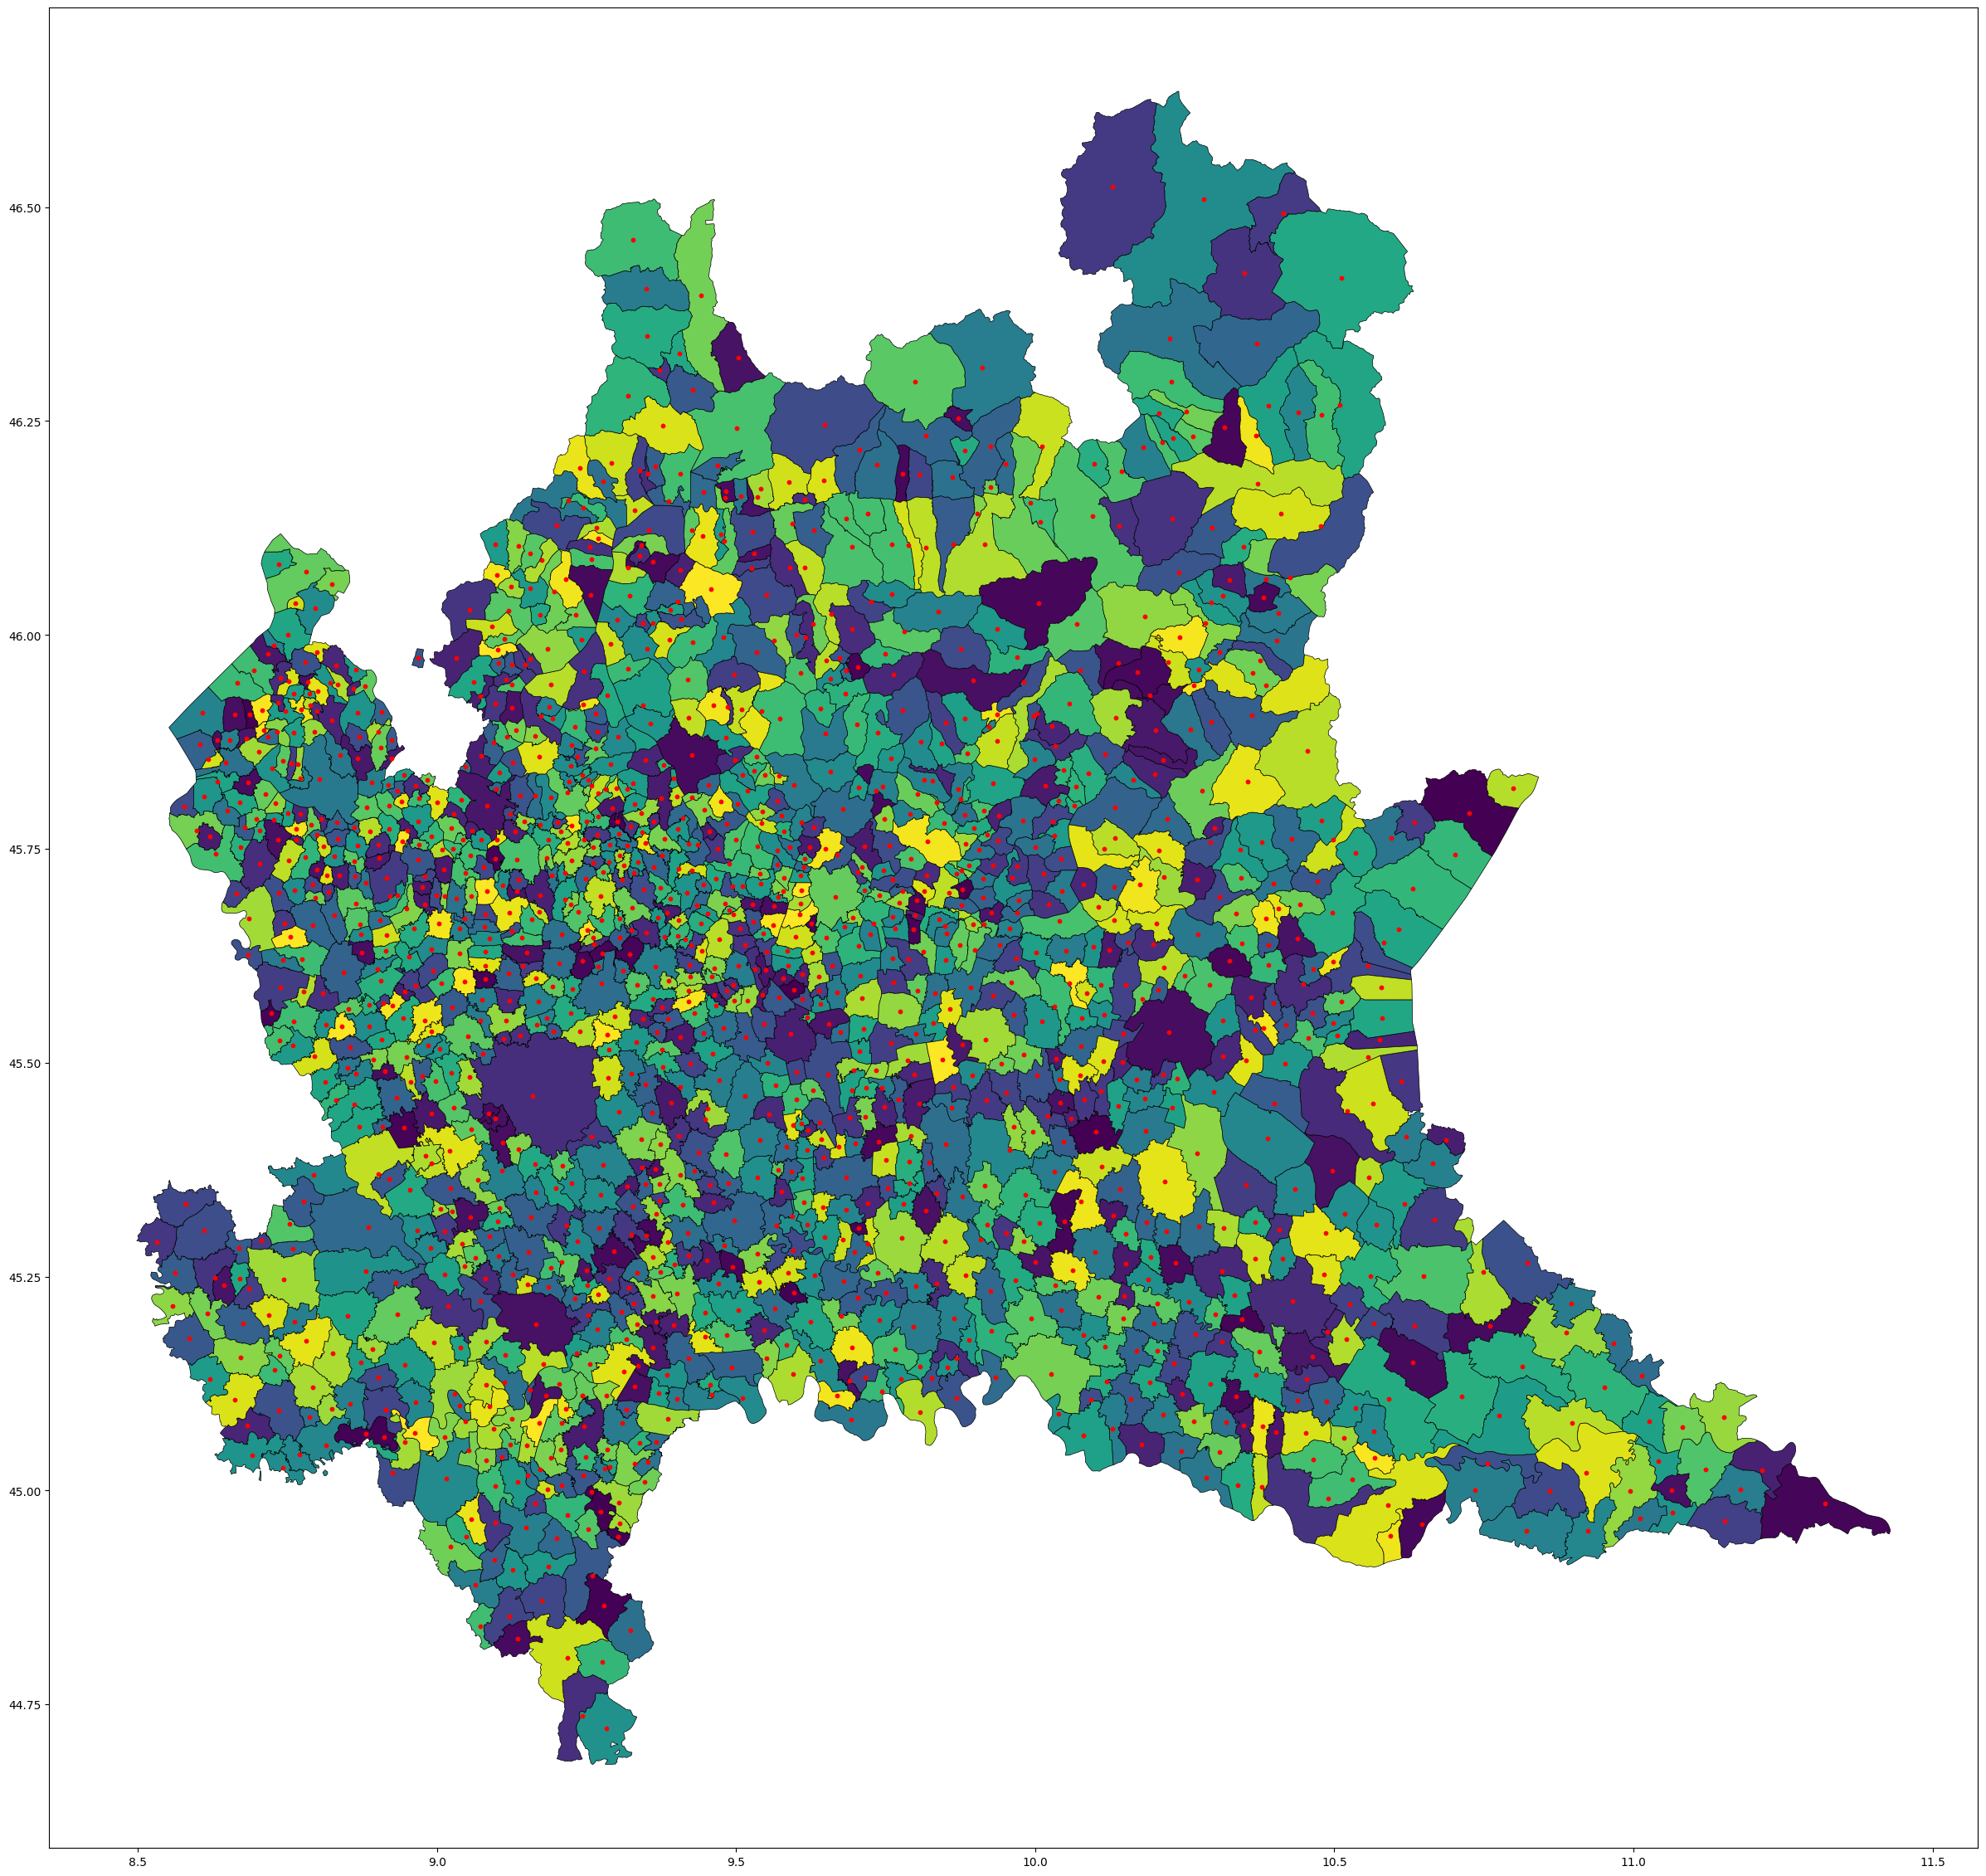

In [37]:
# Set CRS to be the same as that of the map
municipalities_gdf.crs = map.crs

fig, ax = plt.subplots(1, 1, figsize=(30, 30))
map.plot(ax=ax, edgecolor='black', linewidth=0.5, column='OBJECTID')
municipalities_gdf.plot(ax=ax, color='red', markersize=10);

### Plot covariates grid
The following plot shows the grid of the point-referenced covariates against the municipality boundries (and their centroids, in red). The AGC dataset can be found at [here](https://zenodo.org/records/7956006) _(v.3.0.0 May 31, 2023)_.

The code below selects a single day since only latitude and longitute are of interest.


In [38]:
AGC_file = './AGC_Dataset_v_3_0_0.csv' 
AGC_dataset = pd.read_csv(AGC_file)
# convert the dates from string to a correct time format
AGC_dataset['Time'] = pd.to_datetime(AGC_dataset['Time'])

# filter measurements for day January 1, 2018
day_to_analyze = datetime(2018, 1, 1)
AGC_01_JAN_2018 = AGC_dataset[AGC_dataset['Time'] == day_to_analyze]
AGC_01_JAN_2018.head()

/tmp/ipykernel_3593/786842800.py:2: DtypeWarning: Columns (4,5,6,8,10,11,12,13,14,27,28,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  AGC_dataset = pd.read_csv(AGC_file)


,Latitude,Longitude,Time,Altitude,WE_temp_2m,WE_wind_speed_10m_mean,WE_wind_speed_10m_max,WE_mode_wind_direction_10m,WE_tot_precipitation,WE_precipitation_t,...,EM_nh3_agr_waste_burn,EM_nh3_sum,EM_nox_traffic,EM_nox_sum,EM_so2_sum,LI_pigs,LI_bovine,LA_hvi,LA_lvi,LA_land_use
731,44.35,10.05,2018-01-01,1059.615125,4.129,1.339,1.924,N,0.01771,1,...,0.003037,0.2064,0.3729,0.4792,0.07914,0.3815,3.871,1.496,1.412,311
2558,44.35,10.15,2018-01-01,1140.262734,2.883,1.256,1.889,N,0.01688,1,...,0.001429,0.2998,0.7253,0.8112,0.04282,0.3029,5.197,1.727,1.704,311
4385,44.35,10.25,2018-01-01,1127.005950,2.831,1.233,1.914,N,0.01578,1,...,0.001155,0.3843,0.5212,0.5861,0.03668,0.2192,5.511,1.615,1.765,311
6212,44.35,10.35,2018-01-01,914.205930,2.375,1.23,1.935,N,0.01487,1,...,0.000000,0.5379,0.5045,0.5904,0.05791,1.913,9.515,2.488,1.751,311
8039,44.35,10.45,2018-01-01,816.719005,2.518,1.281,1.966,N,0.01393,1,...,0.001179,1.1350,0.6042,0.7793,0.06122,6.946,20.73,2.228,2.213,311


<Axes: >

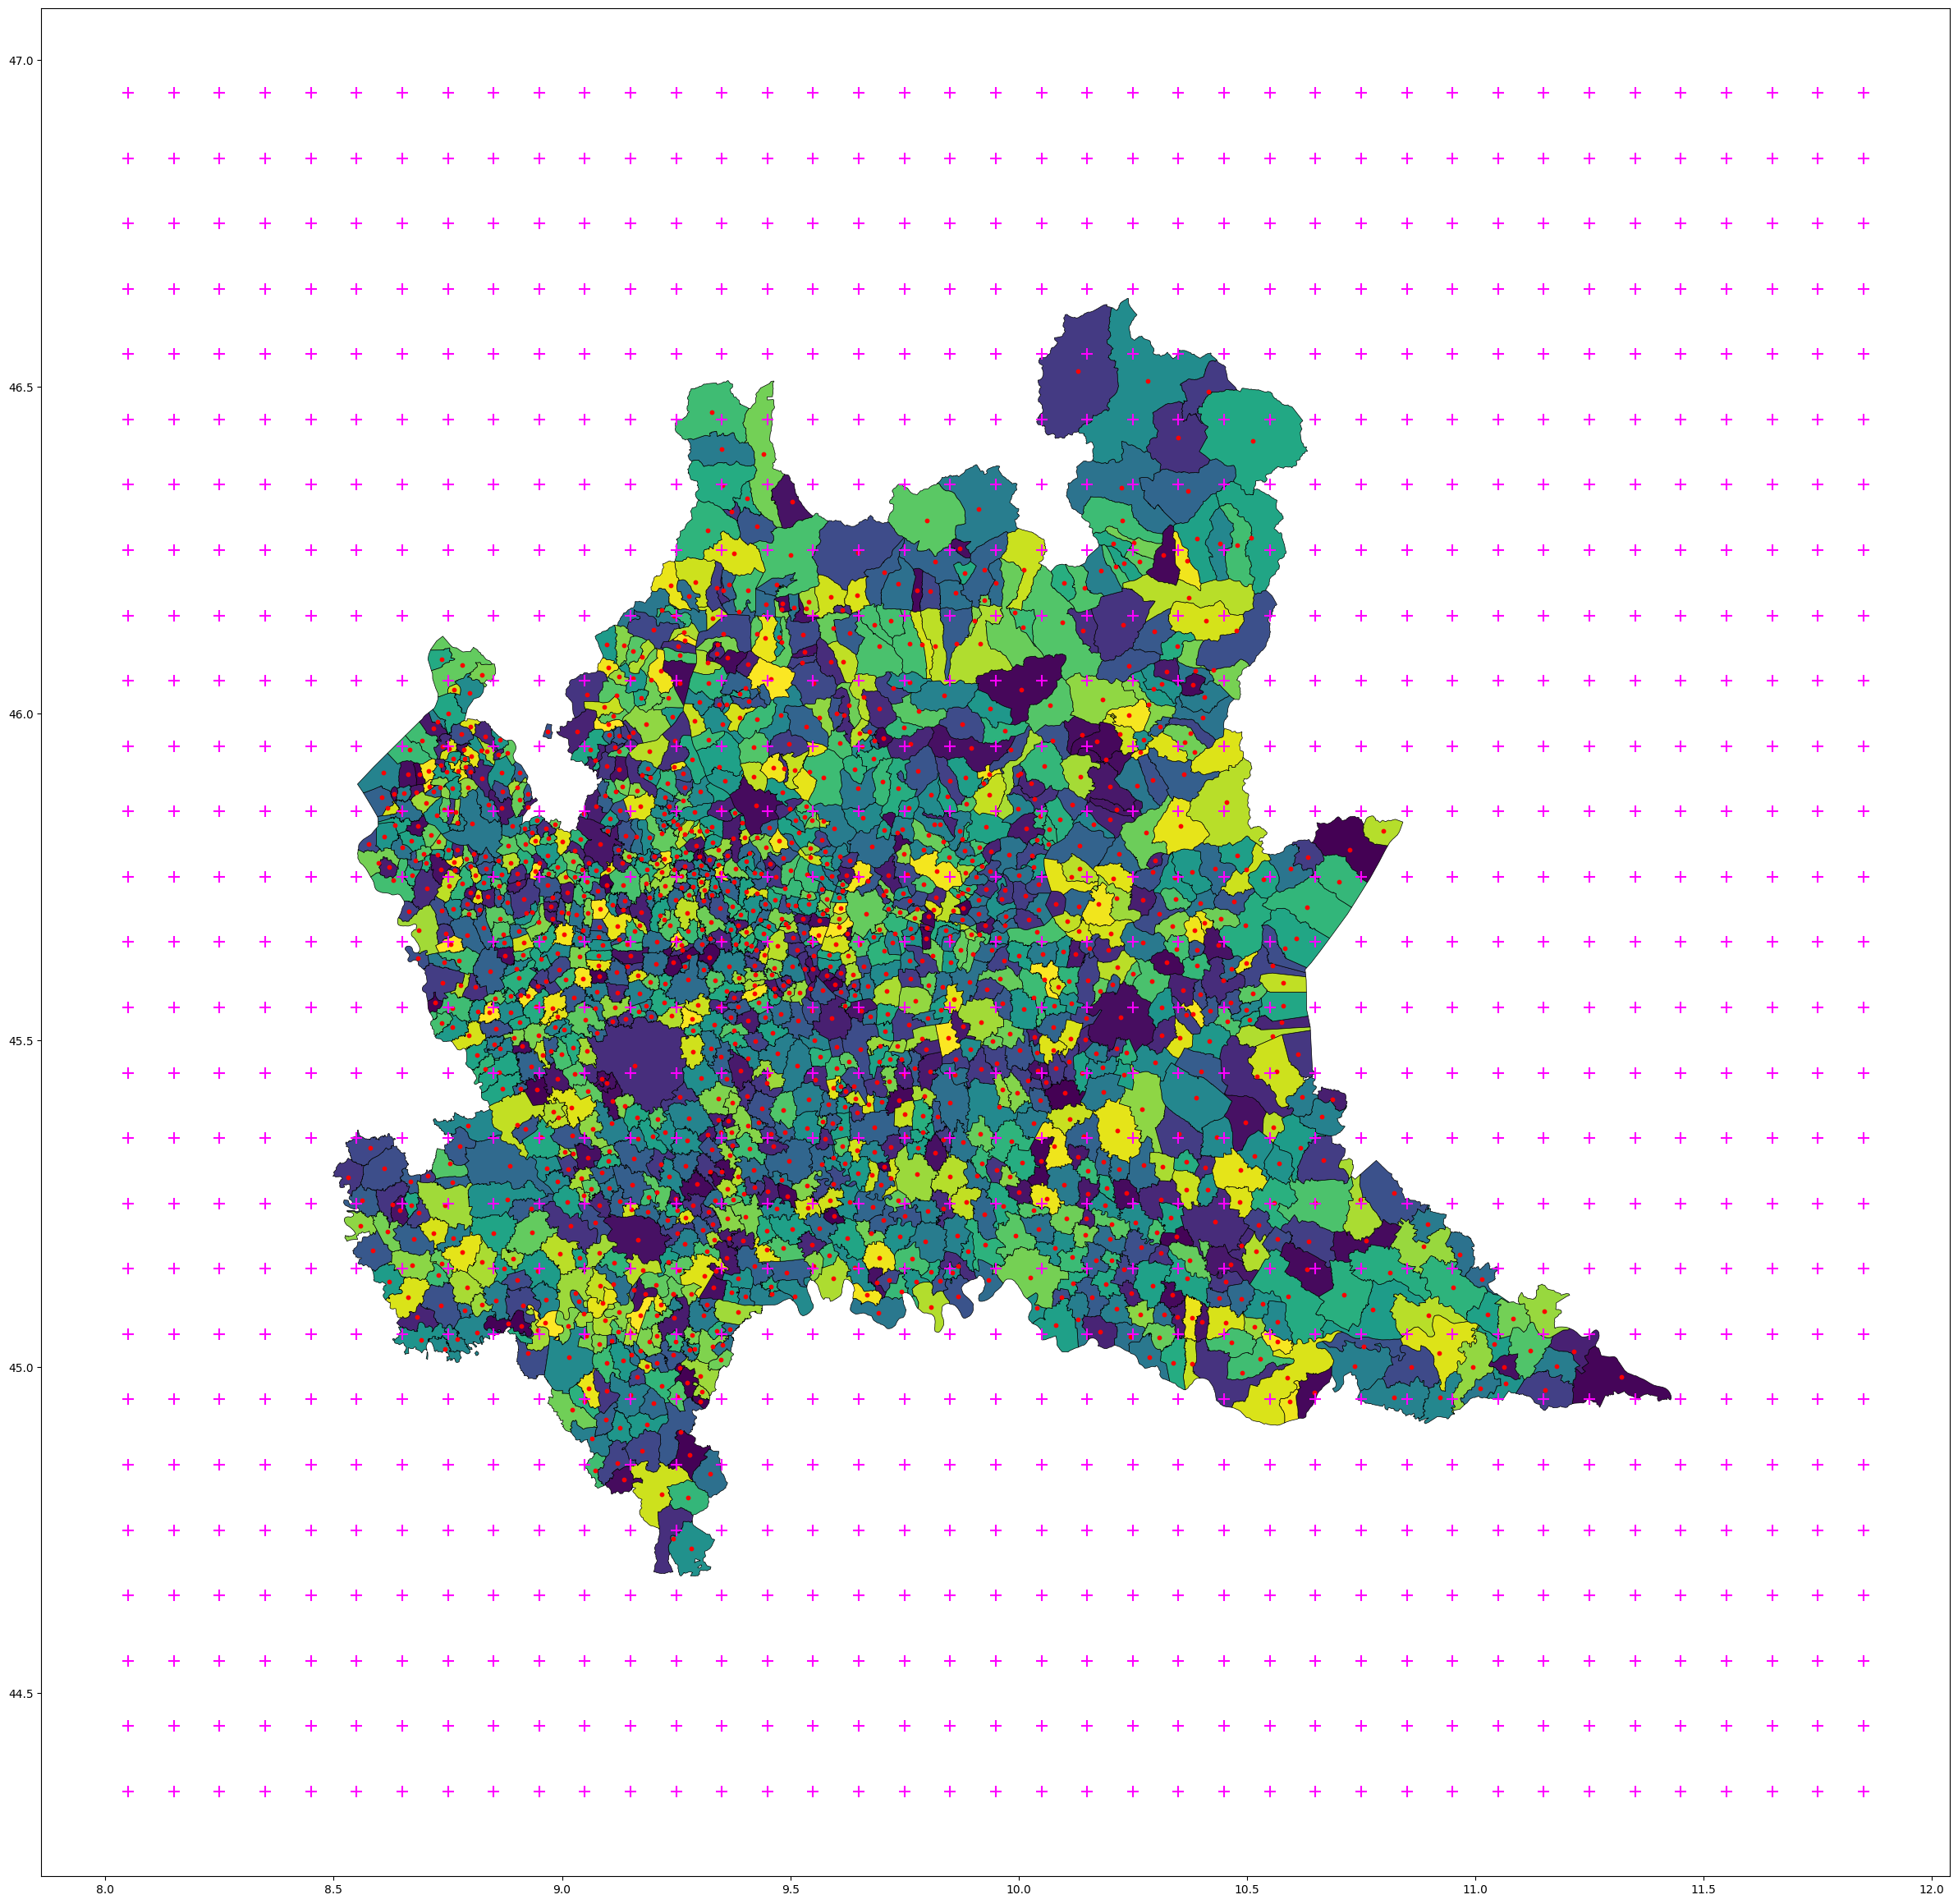

In [39]:
lat = AGC_01_JAN_2018['Latitude']
lon = AGC_01_JAN_2018['Longitude']

grid_geometry = [Point(x, y) for (x, y) in zip(lon, lat)]
grid_gdf = gpd.GeoDataFrame(AGC_01_JAN_2018, geometry=grid_geometry, crs=map.crs)

# plot grid on map
fig, ax = plt.subplots(1, 1, figsize=(30, 30))
map.plot(ax=ax, edgecolor='black', linewidth=0.5, column='OBJECTID')
municipalities_gdf.plot(ax=ax, color='red', markersize=10);
grid_gdf.plot(ax=ax, color='magenta', markersize=100, marker='+')